# Computing Final Metroscores

In this notebook, we'll walk through how to use the metroscore library to compute a score for a single point. Then we'll compute scores for a set of points (i.e. a city)

In [2]:
%load_ext autoreload

%autoreload 2

In [270]:
from typing import Tuple, List
from joblib import Parallel, delayed

import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
import folium
import contextily as cx

import networkx as nx
import osmnx as ox

import metroscore.network_builder as mnb
import metroscore.service_areas as msa
import metroscore.utils as mu

%config InlineBackend.figure_format = 'retina'

## Single Point Metroscore

In [8]:
point = (-73.9964627696242, 40.72953173621136) # Coordinates for NYU WSP Campus 
PLACE = "New York City, NY, USA"

In [10]:
# start by loading in drive network

drive_network = ox.graph_from_place(
    PLACE, 
    retain_all=False, 
    truncate_by_edge=True, 
    simplify=True, 
    network_type='drive'
)
drive_network = ox.project_graph(drive_network)
drive_network = ox.add_edge_speeds(drive_network)
drive_network = ox.add_edge_travel_times(drive_network)

In [207]:
# also load in the walk network
walk_network = ox.graph_from_place(
    "Manhattan, NY, USA",
    retain_all=False,
    truncate_by_edge=True,
    simplify=True,
    network_type='walk',
)
walk_network = ox.project_graph(walk_network)

In [211]:
nx.set_edge_attributes(walk_network, DEFAULT_WALK_SPEED * (60**2 / 1000), name="speed_kph")
walk_network = ox.add_edge_travel_times(walk_network)

In [212]:
from random import choice
def get_random_edge(G):
    edge = choice(list(G.edges(data=True)))
    return edge

In [213]:
get_random_edge(walk_network)

(10171493828,
 10171493827,
 {'osmid': 1111785609,
  'highway': 'footway',
  'oneway': False,
  'reversed': True,
  'length': 6.538,
  'speed_kph': 5.112,
  'travel_time': 4.6})

In [181]:
# save the walk network since it takes forever to load
ox.save_graphml(walk_network, "nyc_walk.graphml")

In [13]:
# we need the gtfs feed for the various modes to get the timetable and to build the networks
mta_subway_feed = mnb.load_gtfs_feed("../data/google_transit.zip")
mta_bus_feed = mnb.load_gtfs_feed("../data/google_transit_manhattan.zip")
subway_timetable = msa.make_timetable(mta_subway_feed.stop_times)
bus_timetable = msa.make_timetable(mta_bus_feed.stop_times)
timetable = pd.concat([subway_timetable, bus_timetable])

In [215]:
def load_network_and_timetable(metro=mta_subway_feed, bus=mta_bus_feed, **kwargs):
    transit_graph = None
    timetable = None
    for mode, feed in ({"metro": metro, "bus": bus} | kwargs).items():
        print(f"Importing {mode} data...")
        if mode == 'walk':
            G = feed
        else:
            node_gdf, edge_gdf, mapping = mnb.build_edge_and_node_gdf(feed)
            print(f"{mode}: \t{node_gdf.shape[0]} nodes \t{edge_gdf.shape[0]} edges")
            G = ox.graph_from_gdfs(node_gdf, edge_gdf)
            _timetable = msa.make_timetable(
                feed.stop_times.assign(
                    stop_id=feed.stop_times['stop_id'].map(lambda x: mapping.get(x, x))
                )
            )
            timetable = pd.concat([timetable, _timetable])
        G = ox.project_graph(G, to_latlong=True)

        # append to transit_graph
        transit_graph = mu.merge_graphs(a=transit_graph, other=G)
    return transit_graph, timetable

In [217]:
len(walk_network.edges)

161568

In [218]:
transit_graph, timetable = load_network_and_timetable(walk=walk_network)

Importing metro data...
metro: 	465 nodes 	2913 edges
Importing bus data...
bus: 	1455 nodes 	14916 edges


/Users/arunavgupta/Documents/metroscore/metroscore/utils.py:99: UserWarning: Mismatched coordinates found. Lon/lat do not match x/y coordinates. When this happens, metroscore will use the x/y coordinates.
Offending node: 101N
  warnings.warn(
/Users/arunavgupta/Documents/metroscore/metroscore/utils.py:99: UserWarning: Mismatched coordinates found. Lon/lat do not match x/y coordinates. When this happens, metroscore will use the x/y coordinates.
Offending node: 103N
  warnings.warn(
/Users/arunavgupta/Documents/metroscore/metroscore/utils.py:99: UserWarning: Mismatched coordinates found. Lon/lat do not match x/y coordinates. When this happens, metroscore will use the x/y coordinates.
Offending node: 104N
  warnings.warn(
/Users/arunavgupta/Documents/metroscore/metroscore/utils.py:99: UserWarning: Mismatched coordinates found. Lon/lat do not match x/y coordinates. When this happens, metroscore will use the x/y coordinates.
Offending node: 106N
  warnings.warn(
/Users/arunavgupta/Documents

Importing walk data...


/Users/arunavgupta/Documents/metroscore/metroscore/utils.py:99: UserWarning: Mismatched coordinates found. Lon/lat do not match x/y coordinates. When this happens, metroscore will use the x/y coordinates.
Offending node: 101N
  warnings.warn(
/Users/arunavgupta/Documents/metroscore/metroscore/utils.py:99: UserWarning: Mismatched coordinates found. Lon/lat do not match x/y coordinates. When this happens, metroscore will use the x/y coordinates.
Offending node: 103N
  warnings.warn(
/Users/arunavgupta/Documents/metroscore/metroscore/utils.py:99: UserWarning: Mismatched coordinates found. Lon/lat do not match x/y coordinates. When this happens, metroscore will use the x/y coordinates.
Offending node: 104N
  warnings.warn(
/Users/arunavgupta/Documents/metroscore/metroscore/utils.py:99: UserWarning: Mismatched coordinates found. Lon/lat do not match x/y coordinates. When this happens, metroscore will use the x/y coordinates.
Offending node: 106N
  warnings.warn(
/Users/arunavgupta/Documents

In [186]:
def plot_graph_interactive(graph):
    m = ox.graph_to_gdfs(graph, nodes=False, edges=True).explore(name="Routes")
    m = ox.graph_to_gdfs(graph, nodes=True, edges=False).explore(m=m, color='red', radius=50, name="Stops")
    folium.LayerControl().add_to(m)   
    return m

In [245]:
DEFAULT_WALK_SPEED = 1.42 # m/s

def get_closest_node(start_points: List[Tuple[float, float]], graph) -> Tuple[int, float]:
    """Get closest node to graph and how long it'll take to get there, in seconds."""
    point_gdf = gpd.GeoDataFrame([(*point, Point(*point)) for point in start_points], geometry=2, crs=4326).to_crs(3857)
    if graph.graph.get('crs') != 3857:
        # need the graph in a projected CRS. Use 3857 for consistency with starting point CRS
        graph = ox.project_graph(graph, to_crs=3857)
    nodes_and_dists = list(zip(*ox.nearest_nodes(G=graph, X=point_gdf.loc[:, 2].x, Y=point_gdf.loc[:, 2].y, return_dist=True)))
    # convert dists into walk time
    return list(map(lambda x: (x[0], x[1] / DEFAULT_WALK_SPEED), nodes_and_dists))

In [221]:
from shapely.geometry import Point

In [222]:
point_list = [point] * 5
len(point_list)

5

In [223]:
%timeit [(*point, Point(*point)) for point in point_list]

11 µs ± 259 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


In [224]:
%timeit Parallel(n_jobs=-1)(delayed(lambda p: (*p, Point(*p)))(point) for point in point_list)

12.7 ms ± 896 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [225]:
point_gdf = gpd.GeoDataFrame([(*point, Point(*point)) for point in point_list], geometry=2, crs=4326).to_crs(3857)
point_gdf

0          1                                 2
0 -73.996463  40.729532  POINT (-8237248.556 4972529.139)
1 -73.996463  40.729532  POINT (-8237248.556 4972529.139)
2 -73.996463  40.729532  POINT (-8237248.556 4972529.139)
3 -73.996463  40.729532  POINT (-8237248.556 4972529.139)
4 -73.996463  40.729532  POINT (-8237248.556 4972529.139)

In [226]:
ox.nearest_nodes(G=transit_graph, X=point_gdf.loc[:, 2].x, Y=point_gdf.loc[:, 2].y, return_dist=True)

([3584752195, 3584752195, 3584752195, 3584752195, 3584752195],
 [4.92395061132529,
  4.92395061132529,
  4.92395061132529,
  4.92395061132529,
  4.92395061132529])

In [227]:
closest_node, start_time_headstart = get_closest_node(start_points=[point], graph=transit_graph)[0]
closest_node, start_time_headstart

(3584752195, 3.4675708530459795)

In [228]:
from dateutil import parser

def start_time_to_seconds(start_time: str):
    return (parser.parse(start_time) - parser.parse("12AM")).seconds

start_time_to_seconds("7AM")

25200

In [229]:
official_start_time = start_time_to_seconds("7AM") - start_time_headstart

In [230]:
# get transitsheds and drivesheds from each of the source nodes
sp = msa.time_dependent_djikstra(
    G=transit_graph,
    timetable=timetable,
    start_time=official_start_time,
    origin_id=closest_node
)

In [231]:
travel_times_from_origin = dict(map(lambda x: (x[0], x[1] - official_start_time),filter(lambda x: x[1] != np.inf, sp.items())))
len(travel_times_from_origin)

48942

In [232]:
cutoffs = list(map(lambda x: x*60, range(10, 60, 10))) # 10, 20, 30, 40, 50 minutes

In [146]:
ox.graph_to_gdfs(transit_graph, edges=False)['geometry']

osmid
101N      POINT (-8226352.630 4996019.468)
103N      POINT (-8226607.218 4995344.928)
104N      POINT (-8227048.488 4994489.339)
106N      POINT (-8227604.752 4993857.009)
107N      POINT (-8228211.220 4993103.714)
                        ...               
402355    POINT (-8232931.723 4977233.857)
405389    POINT (-8233001.409 4977106.141)
404266    POINT (-8233237.406 4976683.766)
402331    POINT (-8232770.978 4977495.759)
405359    POINT (-8236739.852 4969750.692)
Name: geometry, Length: 1920, dtype: geometry

In [147]:
from shapely.geometry import MultiPolygon

In [233]:
node_gdf = ox.graph_to_gdfs(transit_graph, edges=False)
travel_times = travel_times_from_origin
cutoff = 10 * 60

In [236]:
transit_areas = msa.get_transit_areas(
    travel_times_from_origin, 
    cutoffs,
    ox.graph_to_gdfs(transit_graph, edges=False),
)
transit_areas

600     MULTIPOLYGON (((-8238021.394 4972058.536, -823...
1200    MULTIPOLYGON (((-8239151.903 4969213.621, -823...
1800    MULTIPOLYGON (((-8239548.045 4968437.616, -823...
2400    MULTIPOLYGON (((-8239502.565 4968391.485, -823...
3000    MULTIPOLYGON (((-8239624.471 4959500.906, -823...
dtype: geometry

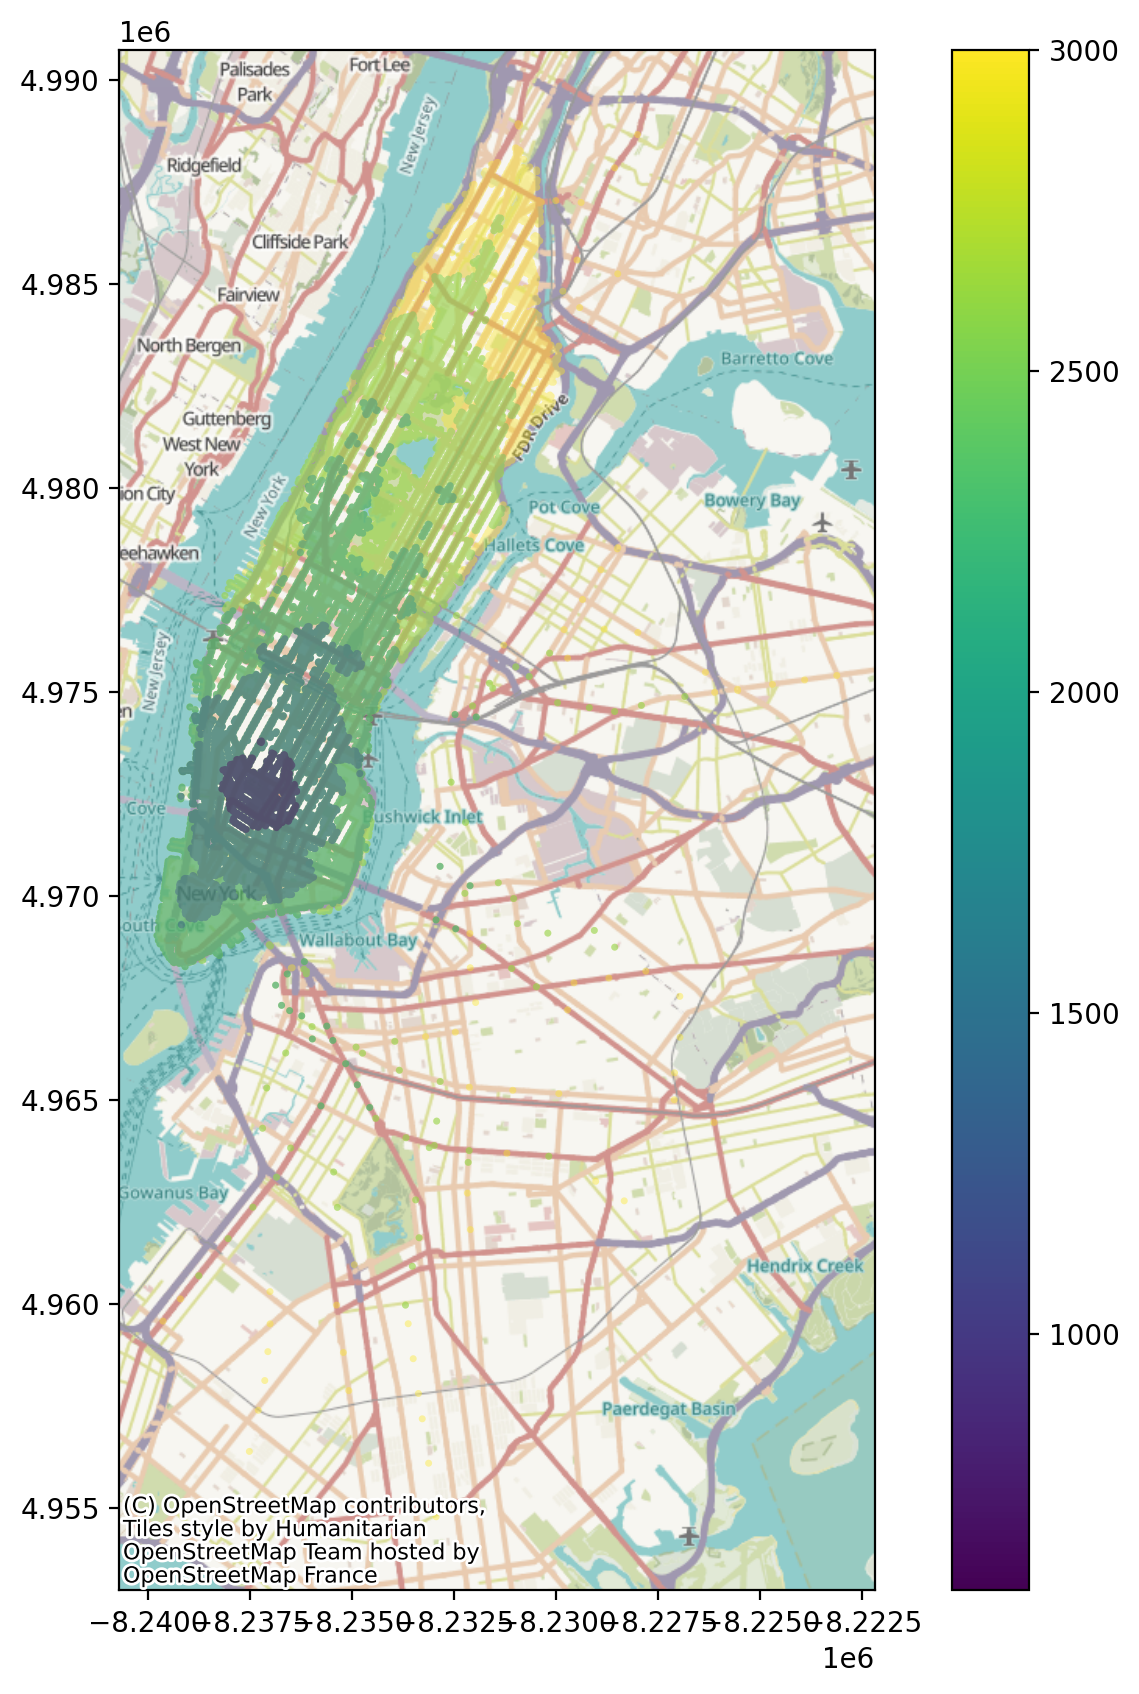

In [237]:
fig, ax = plt.subplots(figsize=(10,10))
transit_areas = gpd.GeoDataFrame(
    transit_areas.sort_index(ascending=False)
).reset_index(drop=False).rename(columns={"index": "cutoffs", 0: "geometry"})
transit_areas = transit_areas.set_geometry('geometry')
transit_areas.plot(alpha=0.4, ax=ax, column='cutoffs', legend=True, cmap='viridis')
cx.add_basemap(ax)

In [246]:
drive_closest_node, drive_time_headstart = get_closest_node([point], drive_network)[0]
drive_closest_node, drive_time_headstart

(42433587, 11.342575240748552)

In [247]:
# Now, get drive_time polygons for the same starting node
time_to_all_paths = nx.single_source_dijkstra_path_length(drive_network, drive_closest_node, weight='travel_time')

In [249]:
max(time_to_all_paths.items(), key=lambda x: x[1])

(3586505208, 2651.3999999999996)

In [251]:
drive_areas = msa.get_transit_areas(
    {k:v+drive_time_headstart for k, v in time_to_all_paths.items()},
    cutoffs,
    ox.graph_to_gdfs(drive_network, edges=False),
)
drive_areas

600     MULTIPOLYGON (((-8239166.061 4968341.074, -823...
1200    MULTIPOLYGON (((-8244569.595 4952840.864, -824...
1800    MULTIPOLYGON (((-8256637.820 4949217.340, -825...
2400    MULTIPOLYGON (((-8263182.525 4939455.380, -826...
3000    MULTIPOLYGON (((-8264567.480 4938566.934, -826...
dtype: geometry

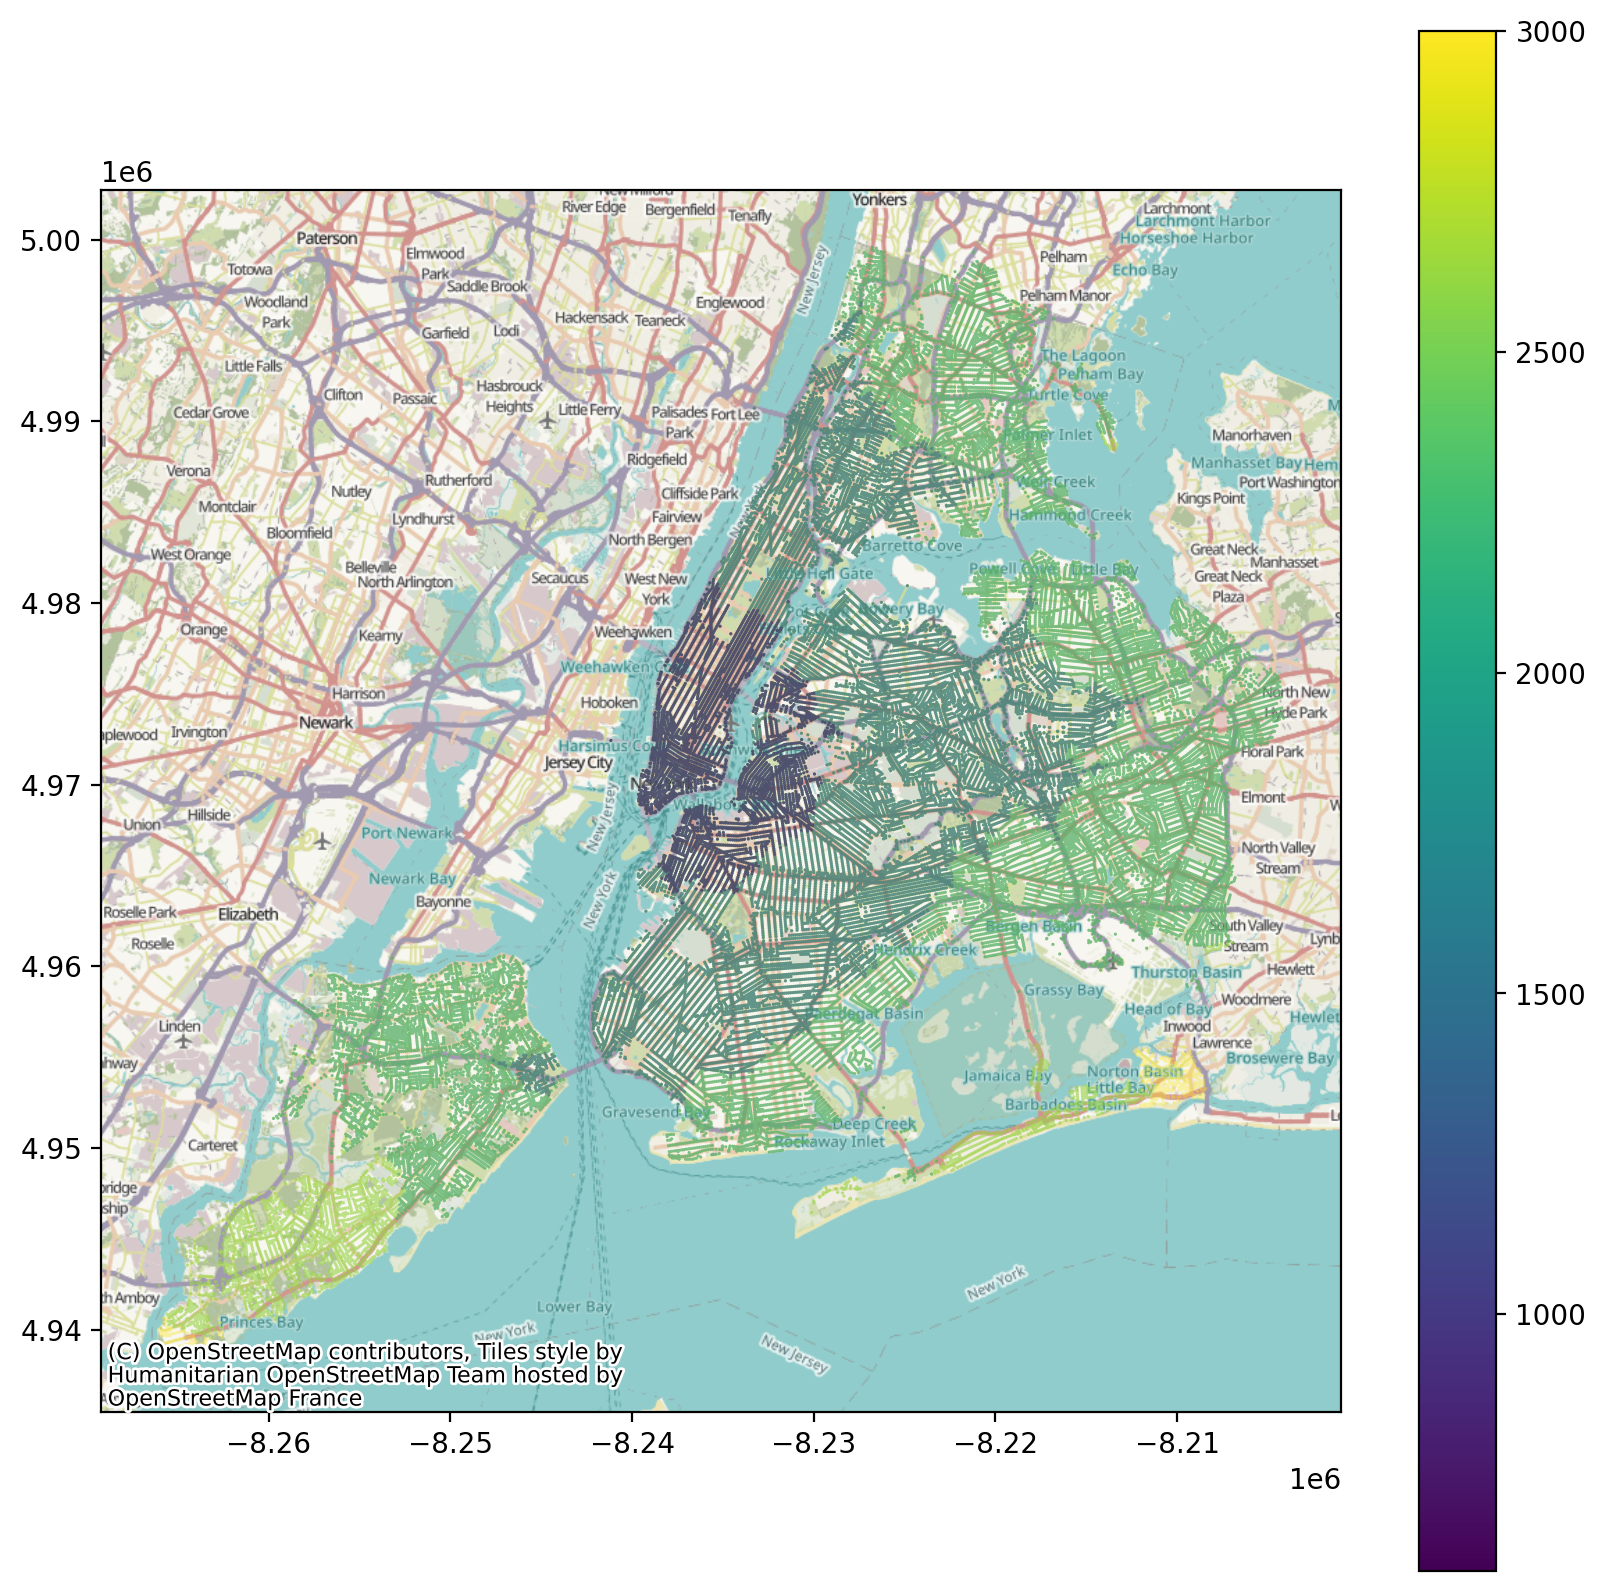

In [252]:
fig, ax = plt.subplots(figsize=(10,10))
drive_areas = gpd.GeoDataFrame(
    drive_areas.sort_index(ascending=False)
).reset_index(drop=False).rename(columns={"index": "cutoffs", 0: "geometry"})
drive_areas = drive_areas.set_geometry('geometry')
drive_areas.plot(alpha=0.4, ax=ax, column='cutoffs', legend=True, cmap='viridis')
cx.add_basemap(ax)

In [253]:
transit_areas

cutoffs                                           geometry
0     3000  MULTIPOLYGON (((-8239624.471 4959500.906, -823...
1     2400  MULTIPOLYGON (((-8239502.565 4968391.485, -823...
2     1800  MULTIPOLYGON (((-8239548.045 4968437.616, -823...
3     1200  MULTIPOLYGON (((-8239151.903 4969213.621, -823...
4      600  MULTIPOLYGON (((-8238021.394 4972058.536, -823...

In [254]:
drive_areas

cutoffs                                           geometry
0     3000  MULTIPOLYGON (((-8264567.480 4938566.934, -826...
1     2400  MULTIPOLYGON (((-8263182.525 4939455.380, -826...
2     1800  MULTIPOLYGON (((-8256637.820 4949217.340, -825...
3     1200  MULTIPOLYGON (((-8244569.595 4952840.864, -824...
4      600  MULTIPOLYGON (((-8239166.061 4968341.074, -823...

In [260]:
joined_sa = pd.merge(
    left=transit_areas.to_crs(3857),
    right=drive_areas.to_crs(3857),
    on='cutoffs',
    how='inner',
    suffixes=('_transit', '_drive'),
)
joined_sa

cutoffs                                   geometry_transit  \
0     3000  MULTIPOLYGON (((-8239624.471 4959500.906, -823...   
1     2400  MULTIPOLYGON (((-8239502.565 4968391.485, -823...   
2     1800  MULTIPOLYGON (((-8239548.045 4968437.616, -823...   
3     1200  MULTIPOLYGON (((-8239151.903 4969213.621, -823...   
4      600  MULTIPOLYGON (((-8238021.394 4972058.536, -823...   

                                      geometry_drive  
0  MULTIPOLYGON (((-16011197.062 2201354.632, -16...  
1  MULTIPOLYGON (((-16010966.899 2202155.627, -16...  
2  MULTIPOLYGON (((-16011729.961 2208065.863, -16...  
3  MULTIPOLYGON (((-16008358.709 2213493.269, -16...  
4  MULTIPOLYGON (((-16011487.326 2221227.854, -16...

In [261]:
joined_sa["area(D)"] = joined_sa['geometry_drive'].area
joined_sa["area(D - T)"] = joined_sa['geometry_drive'].difference(
    joined_sa['geometry_transit']
).area
joined_sa["area(T - D)"] = joined_sa['geometry_transit'].difference(
    joined_sa['geometry_drive']
).area

In [264]:
C = 2.0

In [265]:
joined_sa["TDTC"] = (joined_sa["area(D)"] - joined_sa["area(D - T)"]) / joined_sa[
    "area(D)"
]
joined_sa["TB"] = joined_sa["area(T - D)"] / joined_sa["area(D)"]

# compute final metroscore
joined_sa["Metroscore"] = joined_sa["TDTC"] + (C * joined_sa["TB"])

In [266]:
joined_sa

cutoffs                                   geometry_transit  \
0     3000  MULTIPOLYGON (((-8239624.471 4959500.906, -823...   
1     2400  MULTIPOLYGON (((-8239502.565 4968391.485, -823...   
2     1800  MULTIPOLYGON (((-8239548.045 4968437.616, -823...   
3     1200  MULTIPOLYGON (((-8239151.903 4969213.621, -823...   
4      600  MULTIPOLYGON (((-8238021.394 4972058.536, -823...   

                                      geometry_drive       area(D)  \
0  MULTIPOLYGON (((-16011197.062 2201354.632, -16...  1.843319e+08   
1  MULTIPOLYGON (((-16010966.899 2202155.627, -16...  1.820495e+08   
2  MULTIPOLYGON (((-16011729.961 2208065.863, -16...  1.690900e+08   
3  MULTIPOLYGON (((-16008358.709 2213493.269, -16...  8.405846e+07   
4  MULTIPOLYGON (((-16011487.326 2221227.854, -16...  1.721573e+07   

    area(D - T)   area(T - D)          TDTC        TB  Metroscore  
0  1.843319e+08  7.930612e+07 -1.923962e-14  0.430235    0.860471  
1  1.820495e+08  6.604844e+07 -1.800750e-14  0.362805    0.725610  
2  1.690900e+08  4.156054e+07  1.092758e-14  0.245789    0.491579  
3  8.405846e+07  1.965925e+07 -1.063628e-15  0.233876    0.467752  
4  1.721573e+07  2.981327e+06 -2.163887e-15  0.173175    0.346349

In [267]:
joined_sa['Metroscore'].mean()

0.5783520334666075

Text(0.5, 1.0, 'Metroscore from NYU Central Campus, 7AM')

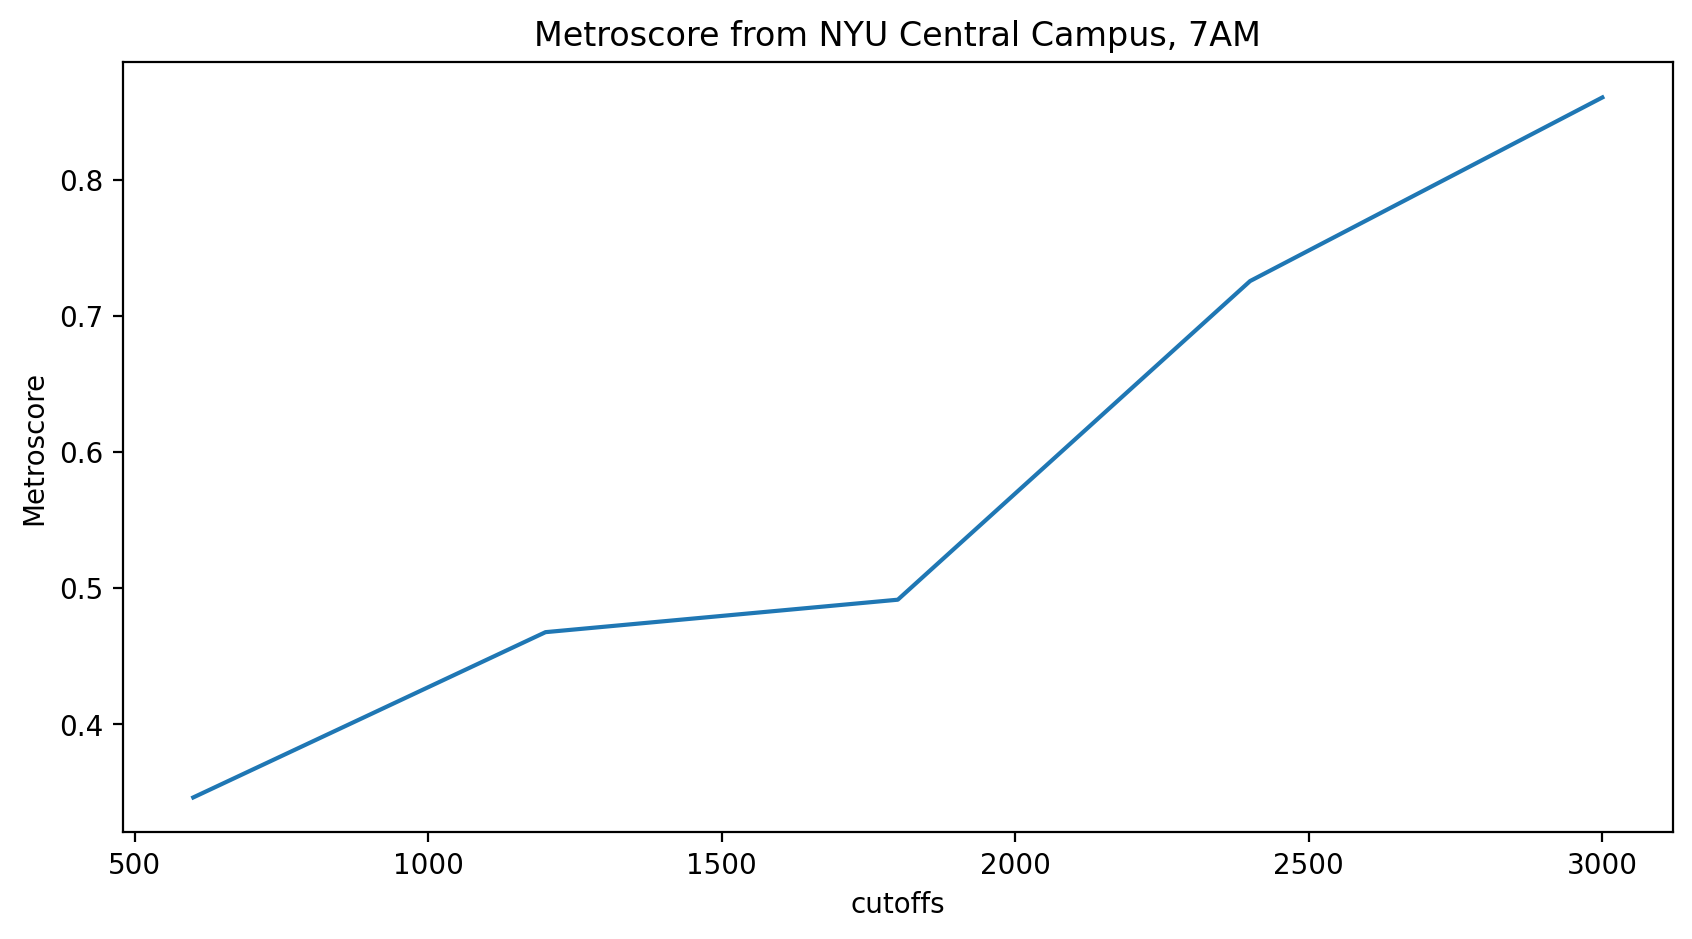

In [278]:
fig, ax = plt.subplots(figsize=(10, 5))
sns.lineplot(data=joined_sa, x='cutoffs', y='Metroscore')
ax.set_title('Metroscore from NYU Central Campus, 7AM')